In [1]:
import os
input_dir = "images/"
target_dir = "annotations/trimaps/"
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")])
target_paths = sorted(
[os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

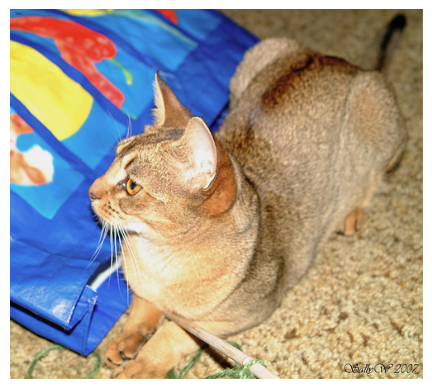

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

In [3]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])
    img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
    display_target(img)

In [4]:
import numpy as np
import random
img_size = (200, 200)
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))
def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [5]:
import tensorflow as tf

# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow is using the GPU:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPU found. TensorFlow is using the CPU.")


TensorFlow is using the GPU:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
import tensorflow as tf

# Enable device placement logging
#tf.debugging.set_log_device_placement(True)

# Perform a computation
'''a = tf.constant([1.0, 2.0, 3.0])
b = tf.constant([4.0, 5.0, 6.0])
result = tf.add(a, b)
print(result)'''


'a = tf.constant([1.0, 2.0, 3.0])\nb = tf.constant([4.0, 5.0, 6.0])\nresult = tf.add(a, b)\nprint(result)'

In [6]:
tf.debugging.set_log_device_placement(False)

define our model

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
        256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
        128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
        64, 3, activation="relu", padding="same", strides=2)(x)
    outputs = layers.Conv2D(num_classes, 3, activation="softmax",
        padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model
model = get_model(img_size=img_size, num_classes=3)

NameError: name 'img_size' is not defined

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [10]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [
keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
save_best_only=True)
]
history = model.fit(train_input_imgs, train_targets,
epochs=50,
callbacks=callbacks,
batch_size=16, #64 oom problem
validation_data=(val_input_imgs, val_targets))

Epoch 1/50
400/400 [==============================] - 70s 147ms/step - loss: 0.9752 - val_loss: 0.8074
Epoch 2/50
400/400 [==============================] - 54s 135ms/step - loss: 0.7281 - val_loss: 0.6536
Epoch 3/50
400/400 [==============================] - 54s 134ms/step - loss: 0.6158 - val_loss: 0.6255
Epoch 4/50
400/400 [==============================] - 54s 135ms/step - loss: 0.5597 - val_loss: 0.4969
Epoch 5/50
400/400 [==============================] - 52s 130ms/step - loss: 0.5118 - val_loss: 0.5350
Epoch 6/50
400/400 [==============================] - 53s 133ms/step - loss: 0.4814 - val_loss: 0.4452
Epoch 7/50
400/400 [==============================] - 53s 133ms/step - loss: 0.4522 - val_loss: 0.4315
Epoch 8/50
400/400 [==============================] - 53s 132ms/step - loss: 0.4298 - val_loss: 0.4340
Epoch 9/50
400/400 [==============================] - 53s 132ms/step - loss: 0.4071 - val_loss: 0.4135
Epoch 10/50
400/400 [==============================] - 53s 132ms/step - l

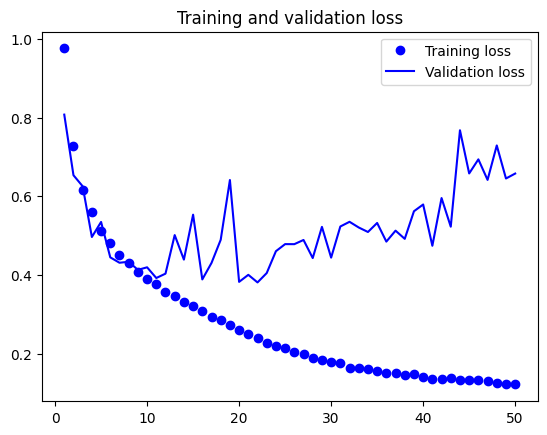

In [11]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

Let’s reload our best
performing model according to the validation loss, and demonstrate how to use it to
predict a segmentation mask

1/1 [==============================] - 2s 2s/step


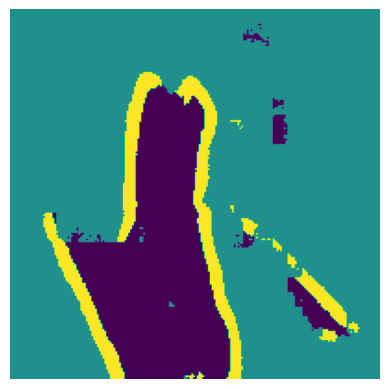

In [12]:
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")
i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
mask = model.predict(np.expand_dims(test_image, 0))[0]
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)
display_mask(mask)

## Modern convnet architecture patterns

### Modularity, hierarchy, and reuse

Residual block where the number of filters changes

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])

Case where the target block includes a max pooling layer

In [14]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])

In [15]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)
def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x
x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 32, 32, 32)   896         ['rescaling_1[0][0]']            
                                                                                                  
 conv2d_14 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_13[0][0]']              
                                                                                            

### Batch normalization

Whenever a reliable explanation is available, I
make sure to mention it. Batch normalization isn’t one of those cases.
In practice, the main effect of batch normalization appears to be that it helps with
gradient propagation—much like residual connections—and thus allows for deeper
networks.

How not to use batch normalization

In [3]:
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.BatchNormalization()(x)

NameError: name 'layers' is not defined

How to use batch normalization: the activation comes last

In [ ]:
x = layers.Conv2D(32, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

The intuitive reason for this approach is that batch normalization will center your
inputs on zero, while your relu activation uses zero as a pivot for keeping or dropping
activated channels: doing normalization before the activation maximizes the utilization of the relu. That said, this ordering best practice is not exactly critical, so if you
do convolution, then activation, and then batch normalization, your model will still
train, and you won’t necessarily see worse results.

On batch normalization and fine-tuning
Batch normalization has many quirks. One of the main ones relates to fine-tuning:
when fine-tuning a model that includes BatchNormalization layers, I recommend
leaving these layers frozen (set their trainable attribute to False). Otherwise they
will keep updating their internal mean and variance, which can interfere with the very
small updates applied to the surrounding Conv2D layers.

### Depthwise separable convolutions

What if I told you that there’s a layer you can use as a drop-in replacement for Conv2D
that will make your model smaller (fewer trainable weight parameters) and leaner
(fewer floating-point operations) and cause it to perform a few percentage points better on its task? That is precisely what the depthwise separable convolution layer does (SeparableConv2D in Keras). This layer performs a spatial convolution on each channel of
its input, independently, before mixing output channels via a pointwise convolution
(a 1 × 1 convolution)

-----------------
As a reminder, here are the convnet architecture principles you’ve learned so far:
 Your model should be organized into repeated blocks of layers, usually made of
multiple convolution layers and a max pooling layer.
 The number of filters in your layers should increase as the size of the spatial feature maps decreases.
 Deep and narrow is better than broad and shallow.
 Introducing residual connections around blocks of layers helps you train
deeper networks.
 It can be beneficial to introduce batch normalization layers after your convolution layers.
 It can be beneficial to replace Conv2D layers with SeparableConv2D layers,
which are more parameter-efficient.

Note that the assumption that underlies
separable convolution, “feature channels are
largely independent,” does not hold for RGB
images! Red, green, and blue color channels
are actually highly correlated in natural
images. As such, the first layer in our model
is a regular Conv2D layer. We’ll start using
SeparableConv2D afterwards.

In [7]:
data_augmentation = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
])
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)
for size in [32, 64, 128, 256, 512]:
    residual = x
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

## Interpreting what convnets learn

he representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts. 

the output of a layer is
often called its activation, the output of the activation function

In [8]:
from tensorflow import keras
model = keras.models.load_model(
"convnet_from_scratch_with_augmentation.keras")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

Preprocessing a single image

In [9]:
from tensorflow import keras
import numpy as np
img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array
img_tensor = get_img_array(img_path, target_size=(180, 180))

80329/80329 [==============================] - 0s 3us/step


Let’s display the picture

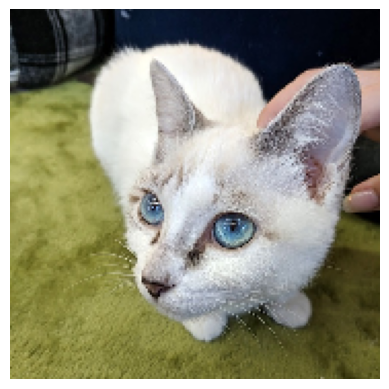

In [10]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

Instantiating a model that returns layer activations

In [12]:
from tensorflow.keras import layers
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the
original model, as a list. This is the first time you’ve encountered a multi-output
model in this book in practice since you learned about them in chapter 7; until now,
the models you’ve seen have had exactly one input and one output. This one has one
input and nine outputs: one output per layer activation.

Using the model to compute layer activations

In [13]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 7s 7s/step


In [14]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


It’s a 178 × 178 feature map with 32 channels. Let’s try plotting the fifth channel of the
activation of the first layer of the original model 

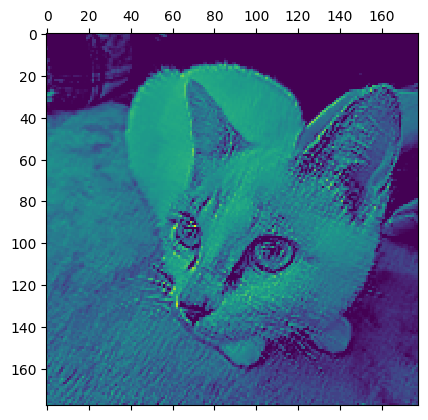

In [15]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

Now, let’s plot a complete visualization of all the activations in the network (see figure 9.14). We’ll extract and plot every channel in each of the layer activations, and
we’ll stack the results in one big grid, with channels stacked side by side.

Visualizing every channel in every intermediate activation

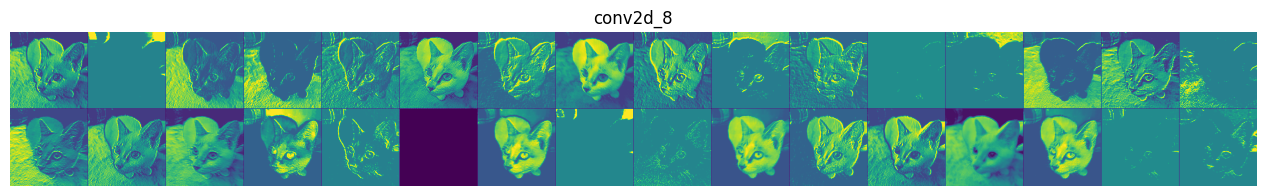

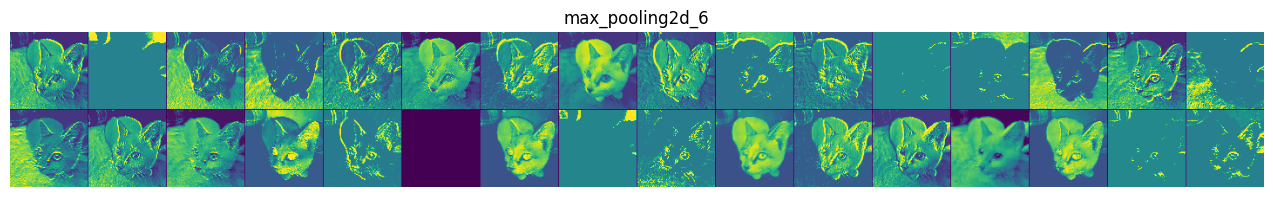

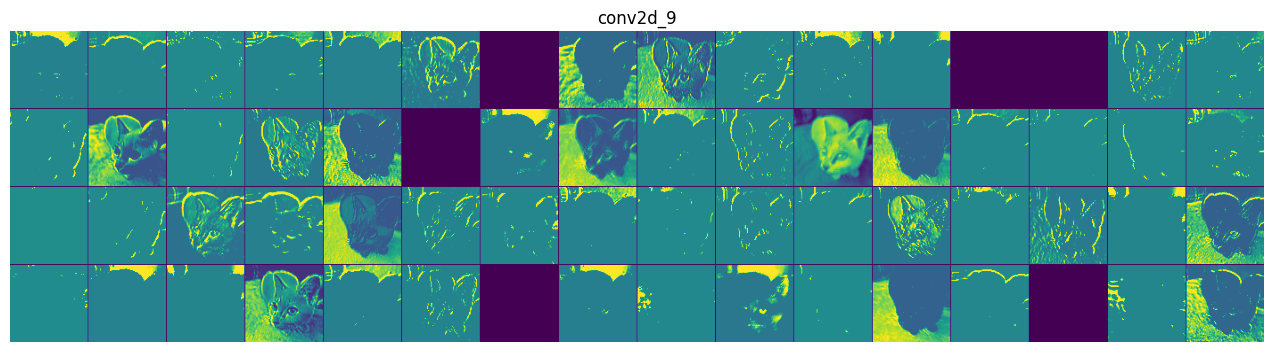

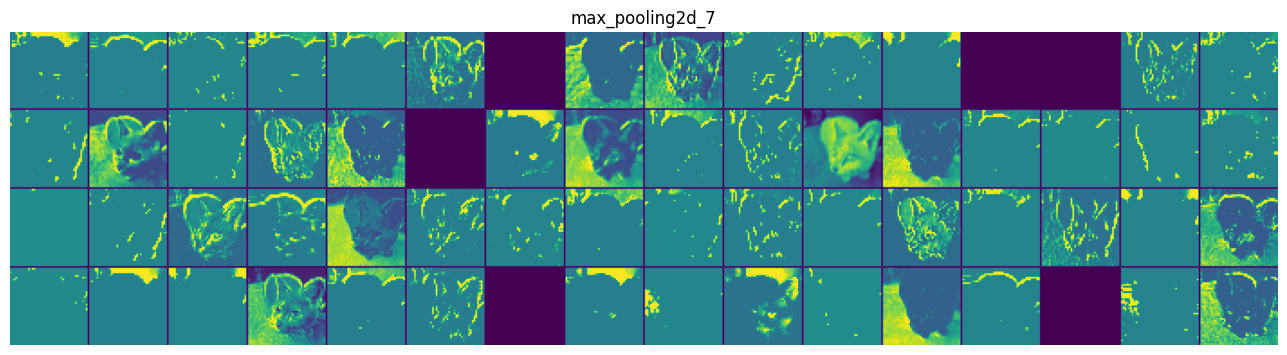

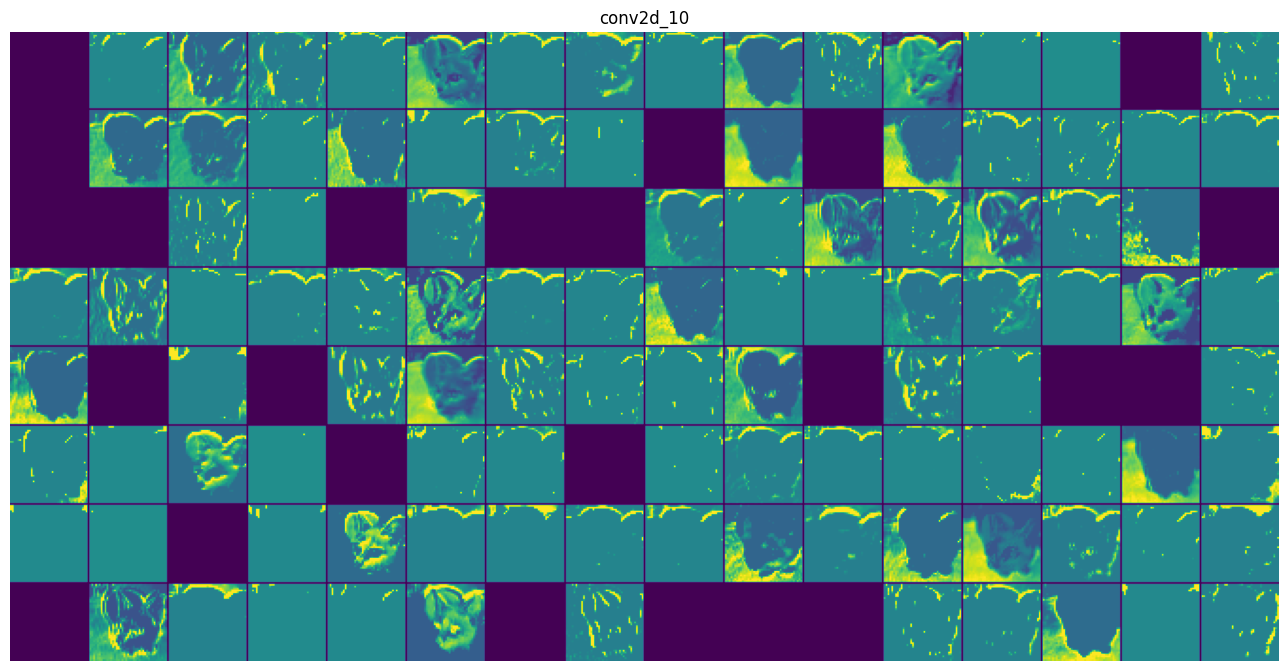

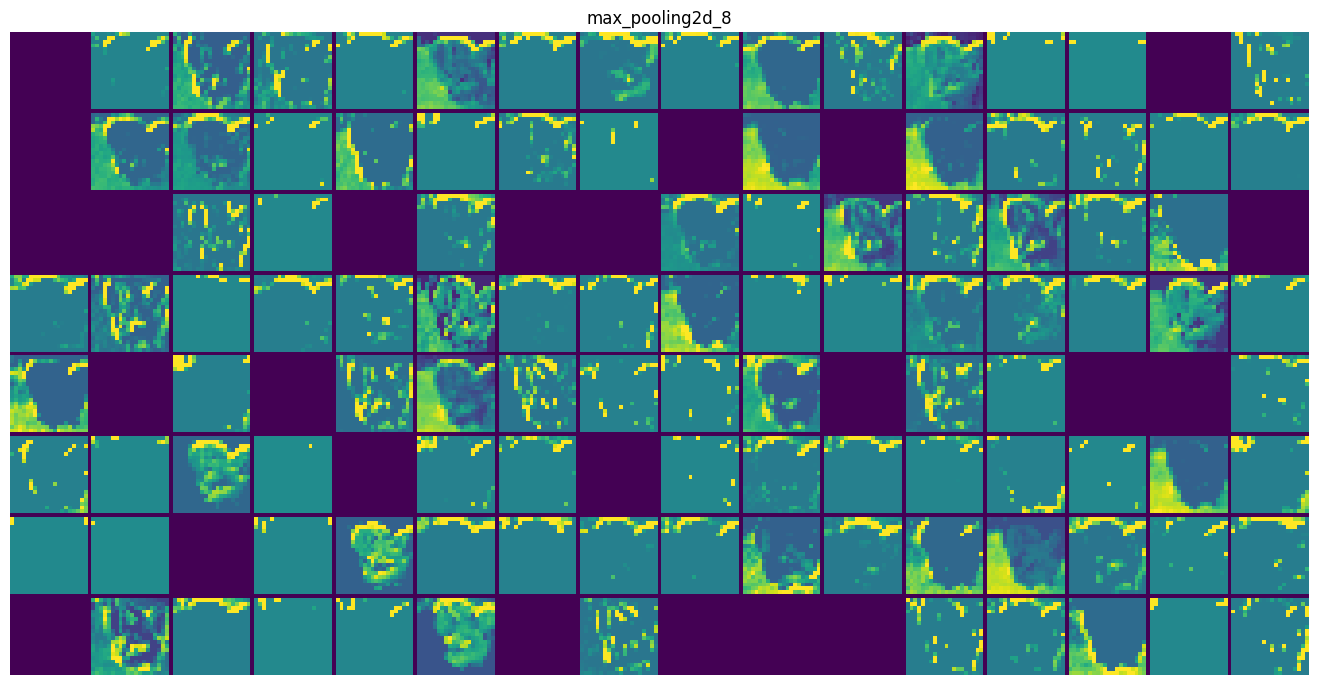

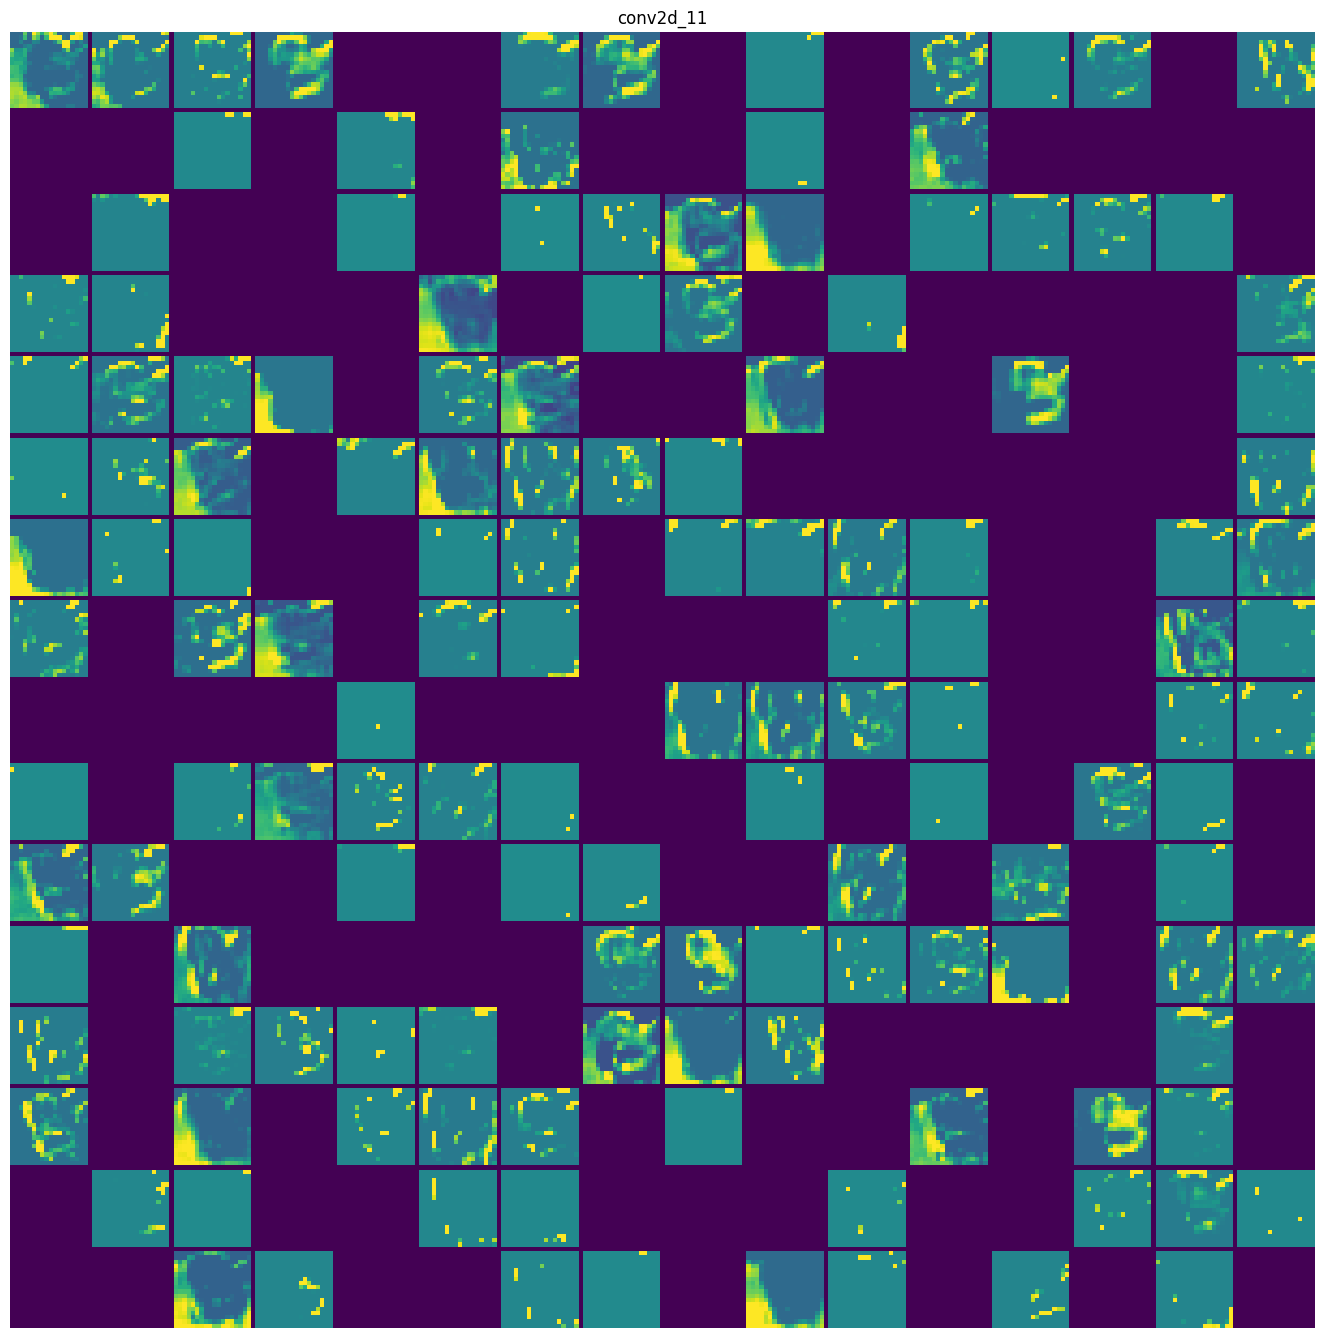

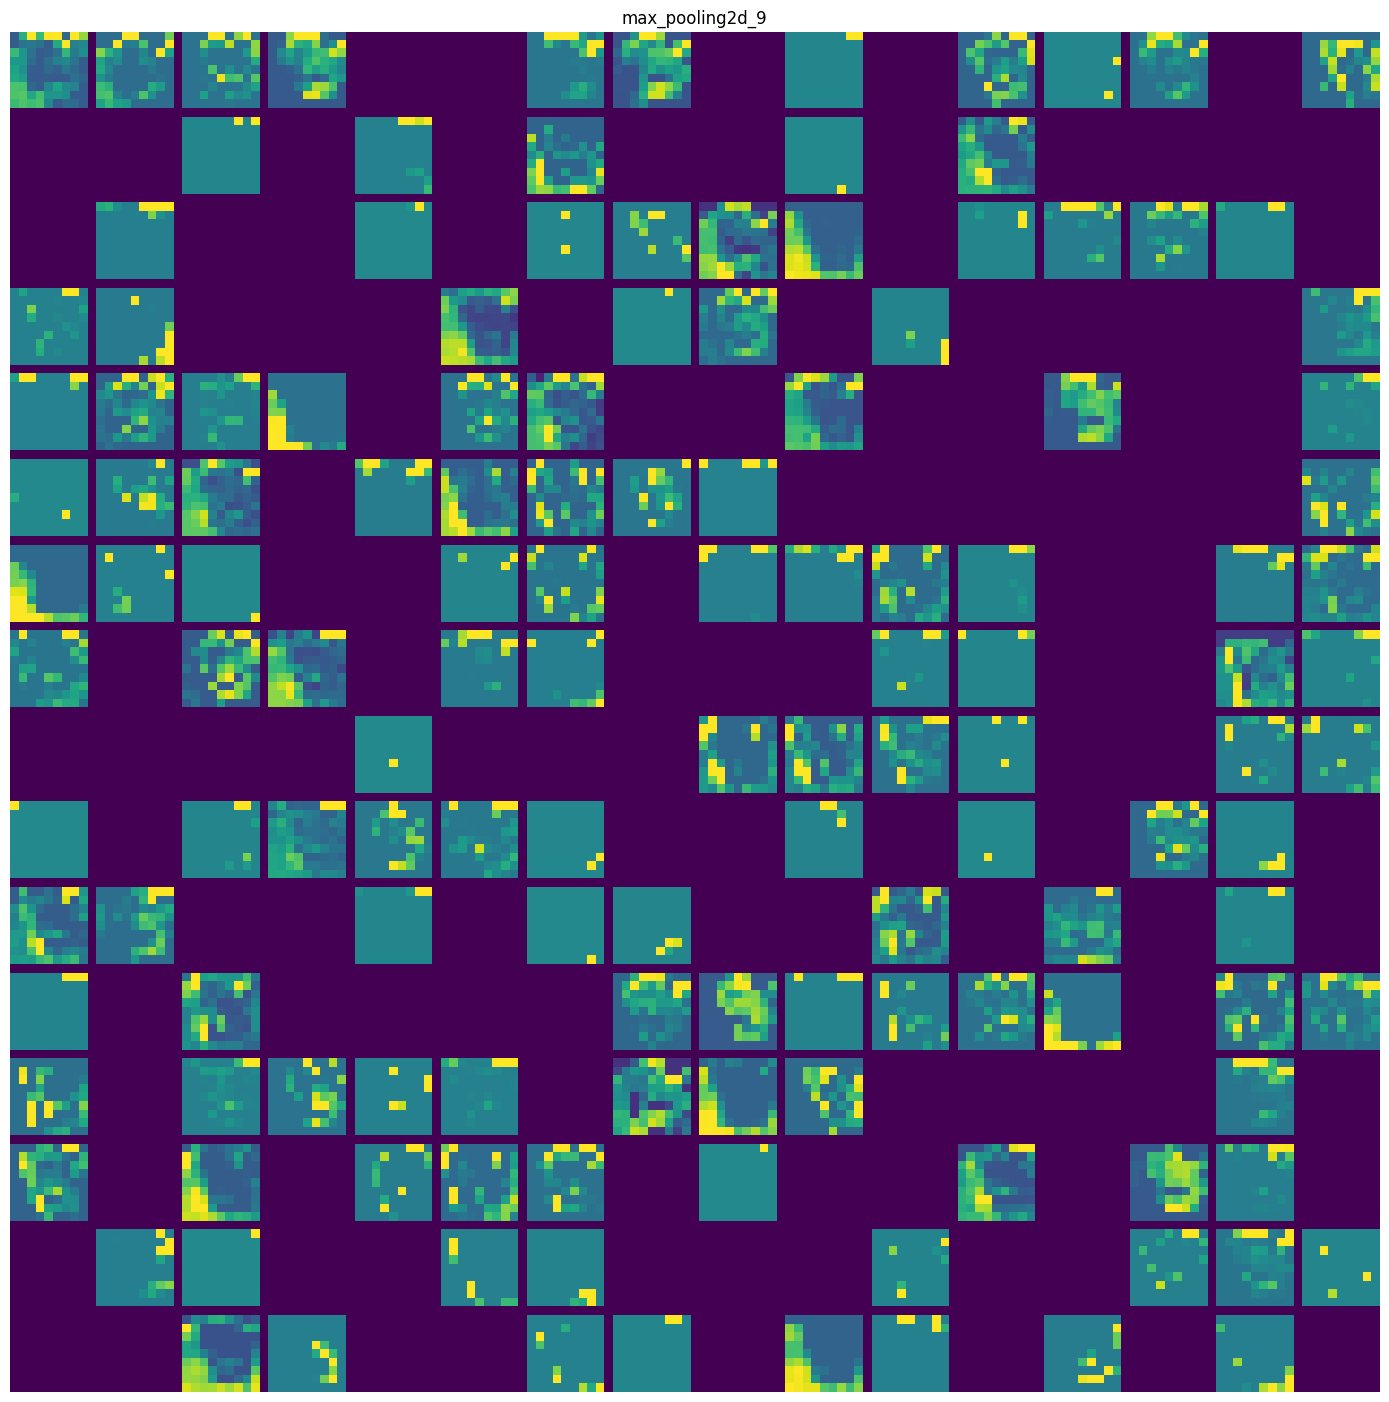

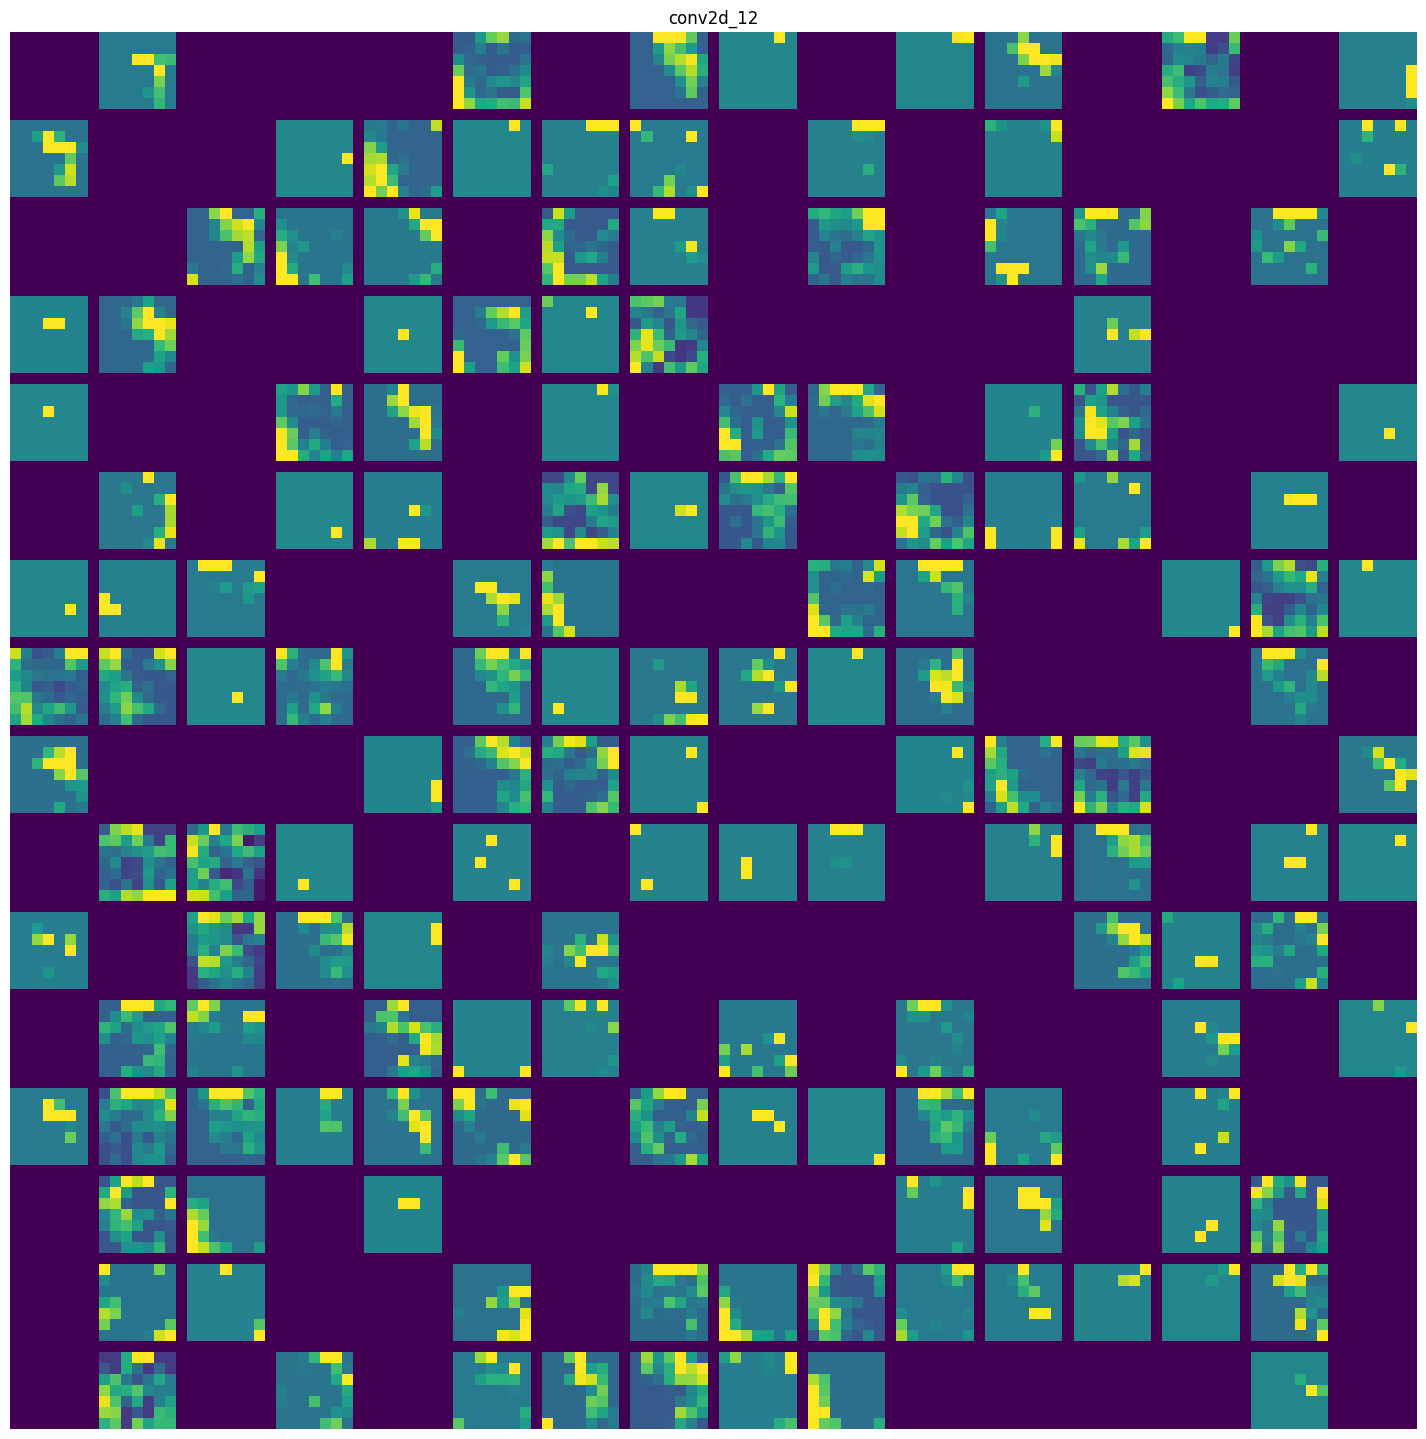

In [16]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]  # Number of features in the activation
    size = layer_activation.shape[1]        # Spatial size (assumes square feature maps)

    n_cols = n_features // images_per_row   # Number of rows in the grid
    display_grid = np.zeros(((size + 1) * n_cols - 1, 
                              images_per_row * (size + 1) - 1))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row

            # Extract the channel activation
            channel_image = layer_activation[0, :, :, channel_index].copy()

            if channel_image.sum() != 0:  # Normalize if non-zero
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype("uint8")

            # Place the channel image in the display grid
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1): (row + 1) * size + row
            ] = channel_image

    # Scale the visualization
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")


We have just evidenced an important universal characteristic of the representations
learned by deep neural networks: the features extracted by a layer become increasingly abstract with the depth of the layer

Let’s try this with the filters of the Xception model, pretrained on ImageNet. The
process is simple: we’ll build a loss function that maximizes the value of a given filter
in a given convolution layer, and then we’ll use stochastic gradient descent to adjust
the values of the input image so as to maximize this activation value. This will be our
second example of a low-level gradient descent loop leveraging the GradientTape
object (the first one was in chapter 2)

Instantiating the Xception convolutional base

In [17]:
model = keras.applications.xception.Xception(
weights="imagenet",
include_top=False)

83683744/83683744 [==============================] - 77s 1us/step


Printing the names of all convolutional layers in Xception

In [18]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_12
block3_sepconv1
block3_sepconv2
conv2d_13
block4_sepconv1
block4_sepconv2
conv2d_14
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_15
block14_sepconv1
block14_sepconv2


Creating a feature extractor model

In [19]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

Using the feature extractor

In [20]:
activation = feature_extractor(
keras.applications.xception.preprocess_input(img_tensor)
)

In [21]:
import tensorflow as tf
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

You should use model(x) when you need to retrieve the gradients of the model call,
and you should use predict() if you just need the output value. In other words,
always use predict() unless you’re in the middle of writing a low-level gradient
descent loop (as we are now)

Loss maximization via stochastic gradient ascent

In [22]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

Now we have all the pieces. Let’s put them together into a Python function that takes
as input a layer name and a filter index, and returns a tensor representing the pattern
that maximizes the activation of the specified filter.

Function to generate filter visualizations

In [27]:
img_width = 200
img_height = 200
def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

The resulting image tensor is a floating-point array of shape (200, 200, 3), with values that may not be integers within [0, 255]. Hence, we need to post-process this tensor to turn it into a displayable image. We do so with the following straightforward
utility function.

Utility function to convert a tensor into a valid image

In [28]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

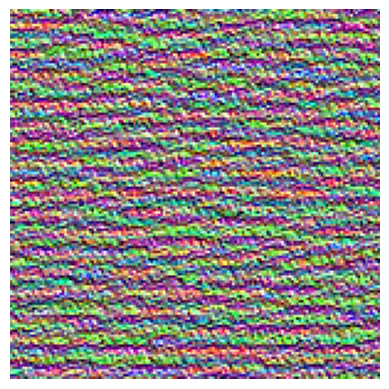

In [29]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

Generating a grid of all filter response patterns in a layer

In [30]:
all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        row_start = (cropped_width + margin) * i
        row_end = (cropped_width + margin) * i + cropped_width
        column_start = (cropped_height + margin) * j
        column_end = (cropped_height + margin) * j + cropped_height
        stitched_filters[
            row_start: row_end,
            column_start: column_end, :
        ] = image  # Closing bracket added correctly here

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters
)


Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

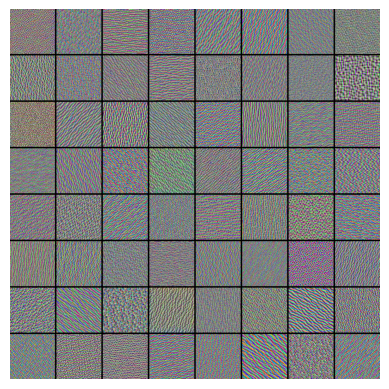

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the PNG file (base directory)
image_path = "filters_for_layer_block3_sepconv1.png"
img = mpimg.imread(image_path)

# Plot the image
plt.imshow(img)
plt.axis("off")  # Turn off axes for better visualization
plt.show()


The specific implementation we’ll use is the one described in an article titled “GradCAM: Visual Explanations from Deep Networks via Gradient-based Localization.”

Loading the Xception network with pretrained weights

In [33]:
model = keras.applications.xception.Xception(weights="imagenet")

91884032/91884032 [==============================] - 81s 1us/step


In [34]:
img_path = keras.utils.get_file(
fname="elephant.jpg",
origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array
img_array = get_img_array(img_path, target_size=(299, 299))

733657/733657 [==============================] - 2s 2us/step


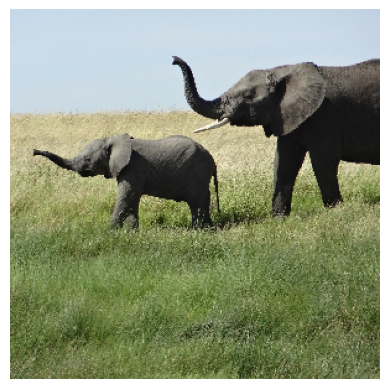

In [35]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img

# Load the image using keras.utils.load_img
img = load_img(img_path, target_size=(299, 299))  # Same target size as in the function

# Display the image
plt.imshow(img)
plt.axis("off")  # Turn off axes for better visualization
plt.show()


In [36]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 3us/step
[('n02504458', 'African_elephant', 0.86978954), ('n01871265', 'tusker', 0.077024326), ('n02504013', 'Indian_elephant', 0.02360241)]


In [38]:
 np.argmax(preds[0])

386

To visualize which parts of the image are the most African-elephant–like, let’s set up
the Grad-CAM process.
First, we create a model that maps the input image to the activations of the last
convolutional layer

Setting up a model that returns the last convolutional output

In [39]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
"avg_pool",
"predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

Second, we create a model that maps the activations of the last convolutional layer to
the final class predictions.

Reapplying the classifier on top of the last convolutional output

In [40]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

Then we compute the gradient of the top predicted class for our input image with
respect to the activations of the last convolution layer.

Retrieving the gradients of the top predicted class

In [41]:
import tensorflow as tf
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
grads = tape.gradient(top_class_channel, last_conv_layer_output)

Now we apply pooling and importance weighting to the gradient tensor to obtain our
heatmap of class activation.

In [42]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

For visualization purposes, we’ll also normalize the heatmap between 0 and 1

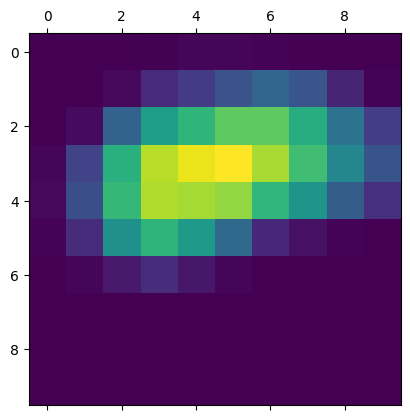

In [43]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

Finally, let’s generate an image that superimposes the original image on the heatmap
we just obtained

In [44]:
import matplotlib.cm as cm
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_15028\3794771049.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


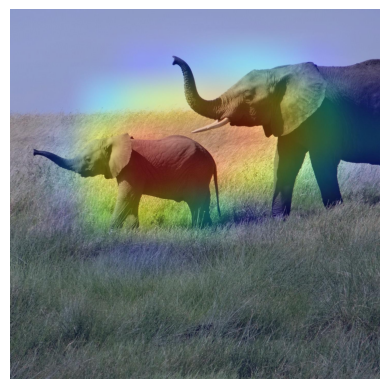

In [45]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img

# Path to the image in the base directory
img_path = "elephant_cam.jpg"

# Load and display the image
img = load_img(img_path)
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()


it’s interesting to note that the ears of the elephant calf are strongly activated: this is probably how the network can tell the difference between African and
Indian elephants.

There are three essential computer vision tasks you can do with deep learning:
image classification, image segmentation, and object detection.
 Following modern convnet architecture best practices will help you get the
most out of your models. Some of these best practices include using residual
connections, batch normalization, and depthwise separable convolutions.
 The representations that convnets learn are easy to inspect—convnets are the
opposite of black boxes!
 You can generate visualizations of the filters learned by your convnets, as well as
heatmaps of class activity